# 4. DETECTION ET ANALYSE DES OUTLIERS


### Objectif : 
#### Identifier les valeurs extrêmes qui peuvent fausser les statistiques et les modèles.

## A) IMPORT DES DATAS

In [33]:
import pandas as pd

df = pd.read_csv("../6.Data/kaggle_b2_fraud_train_v3.csv")

In [34]:
df.head()

,customer_id,account_id,age,tenure_months,annual_income_eur,credit_score,num_transactions_30d,avg_amount_30d_eur,max_amount_30d_eur,days_since_last_login,...,internal_signal_5,internal_signal_6,internal_signal_7,internal_signal_8,terms_accepted_flag,partner_risk_indicator,manual_review_result,post_event_status_code,chargeback_resolution_time_days,legacy_partner_score
0,CUST_6O9Q8D4I36,ACC_TXXXTNEUVKFY,34,108,38635.01,544.0,20,60.92,80.16,4.9,...,0.39006,0.10963,0.55097,-0.56104,1,NaN,approve,0,7.9,NaN
1,CUST_FGUGTW230C,ACC_70VD7A4FFWCW,48,2,19912.97,703.0,21,112.11,571.12,0.3,...,0.03265,-0.40256,0.36218,0.86583,1,NaN,approve,0,5.5,NaN
2,CUST_8ZI3LCBZ0W,ACC_AF53381QSC0L,27,0,20326.87,720.0,25,73.61,492.57,4.6,...,-0.15637,0.57818,0.28902,-2.19864,1,NaN,approve,0,7.2,NaN
3,CUST_5MP3AR41CJ,ACC_U7WZGJ486LIV,45,49,38452.47,703.0,17,47.53,204.18,25.3,...,-1.02145,0.63908,-0.89190,-0.81592,1,NaN,approve,0,4.4,NaN
4,CUST_GNPL83JB0J,ACC_XW7DS3ED5J4Y,37,46,NaN,594.0,13,99.95,734.09,12.8,...,-0.65771,0.08020,0.17606,0.86739,1,NaN,approve,0,4.9,NaN


## B) Identifier les colonnes concernées

In [35]:
#On garde que les colonnes numériques
df_numerique = df.select_dtypes(include='number')

#On Garde que les colonnes numériques qui peuvent avoir des outliers , ou qui ne sont pas catégorielles avec des chiffres
colonne_a_enlever = ['is_vpn','is_new_device','postal_code']

# DataFrame sans ces colonnes
df_sans = df_numerique.drop(columns=colonne_a_enlever)

# DataFrame avec seulement ces colonnes
df_avec = df_numerique[colonne_a_enlever]
df_sans

,age,tenure_months,annual_income_eur,credit_score,num_transactions_30d,avg_amount_30d_eur,max_amount_30d_eur,days_since_last_login,support_tickets_90d,chargebacks_12m,...,internal_signal_4,internal_signal_5,internal_signal_6,internal_signal_7,internal_signal_8,terms_accepted_flag,partner_risk_indicator,post_event_status_code,chargeback_resolution_time_days,legacy_partner_score
0,34,108,38635.01,544.0,20,60.92,80.16,4.9,1,0,...,-1.54627,0.39006,0.10963,0.55097,-0.56104,1,NaN,0,7.9,NaN
1,48,2,19912.97,703.0,21,112.11,571.12,0.3,0,0,...,-0.00054,0.03265,-0.40256,0.36218,0.86583,1,NaN,0,5.5,NaN
2,27,0,20326.87,720.0,25,73.61,492.57,4.6,1,0,...,-0.32183,-0.15637,0.57818,0.28902,-2.19864,1,NaN,0,7.2,NaN
3,45,49,38452.47,703.0,17,47.53,204.18,25.3,1,0,...,1.35968,-1.02145,0.63908,-0.89190,-0.81592,1,NaN,0,4.4,NaN
4,37,46,NaN,594.0,13,99.95,734.09,12.8,0,1,...,1.65795,-0.65771,0.08020,0.17606,0.86739,1,NaN,0,4.9,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159995,56,0,34775.62,727.0,21,51.72,226.11,3.8,0,0,...,0.35144,-2.54086,-0.60747,0.23252,-0.06215,1,-1.535486,0,1.0,NaN
159996,41,4,88617.57,770.0,18,NaN,171.07,15.1,1,0,...,0.33237,0.34098,-1.78817,0.31788,0.51072,1,NaN,0,7.4,NaN
159997,30,2,41148.54,738.0,20,29.34,119.81,0.7,0,0,...,0.84880,-1.28947,-0.32324,-0.06238,-0.99076,1,NaN,3,6.6,NaN
159998,56,6,NaN,719.0,25,88.56,553.16,22.6,2,0,...,-1.87471,0.47179,-0.22090,-1.34239,-0.30513,1,NaN,0,12.5,NaN


## C) Detection des Outliers avec l’IQR

In [36]:
Q1, Q3 = df_sans.quantile(0.25), df_sans.quantile(0.75)
Q1, Q3 = Q1.align(Q3, axis=0)
IQR = Q3 - Q1
borne_inf = Q1 - 2 * IQR
borne_sup = Q3 + 2 * IQR
outliers = ((df_sans < borne_inf) | (df_sans > borne_sup))
outliers.sum()



age                                  210
tenure_months                       4054
annual_income_eur                   3695
credit_score                          85
num_transactions_30d                 316
avg_amount_30d_eur                  2184
max_amount_30d_eur                  3931
days_since_last_login               4449
support_tickets_90d                 1494
chargebacks_12m                     7802
failed_payments_6m                    72
device_trust_z                         0
ip_risk_z                              0
num_devices_30d                     1631
target_is_fraud                     4924
income_log                           101
income_estimate_alt_eur             3778
credit_score_norm                     82
tx_amount_total_30d_eur             3038
max_to_avg_ratio                       0
internal_signal_1                    132
internal_signal_2                    116
internal_signal_3                    131
internal_signal_4                    122
internal_signal_

## D) Detection des Outliers avec le Z-score

In [37]:
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df_sans)) 
outliers_z = (z_scores > 3)  
nb_outliers_par_col = outliers_z.sum(axis=0)  
print(nb_outliers_par_col)

[ 407 2927    0    0  127    0    0 2927 1494 7802  834    0    0 1631
 4924  438 2625  495 2442    0  432  432  466  415  438  486  417  438
    0    0 9583 3272    0]


C:\Users\yannc\AppData\Local\Temp\ipykernel_8300\3861318389.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(stats.zscore(df_sans))


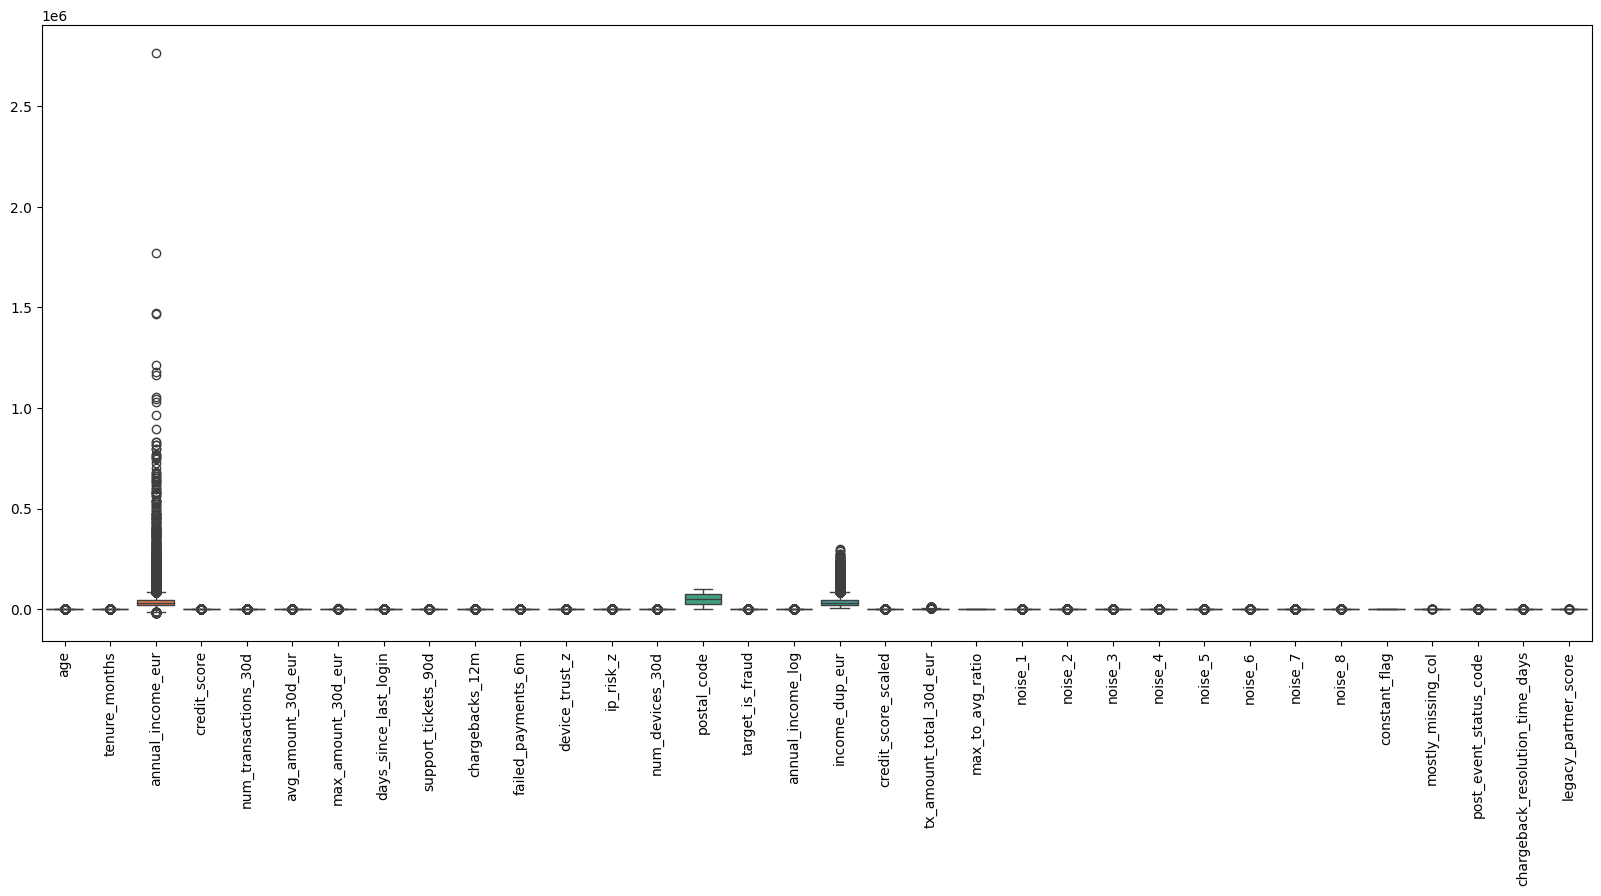

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,8))
sns.boxplot(data=df_sans)
plt.xticks(rotation=90)
plt.show()
